In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from aging.plotting import figure, format_plots

In [71]:
format_plots()

In [139]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_raw_counts_matrix_v00.parquet')
df = df[keep_syllables]

bins = pd.cut(df.index.get_level_values('age'), 92, labels=False)

idx = list(df.index.names)

sample = df.reset_index().groupby(['mouse', bins], observed=True).first()
sample.index.rename("bin", level=1, inplace=True)
sample_map = sample.groupby('bin')['age'].mean()
sample = sample.reset_index().set_index(idx)

sample = sample.reset_index(level='age')
sample['age'] = sample['bin'].map(sample_map)

sample = sample.set_index(["bin", "age"], append=True)

In [140]:
age_avg = sample.groupby('age').mean()

In [141]:
resid_df = sample.droplevel(['subject_name', 'session_name', 'uuid', 'date'])

In [142]:
resid_df = resid_df - age_avg

In [144]:
animal_bias = resid_df.groupby('mouse').mean()

In [145]:
mouse_norm = {}
for mouse, _df in resid_df.groupby('mouse'):
    mouse_norm[mouse] = pd.Series(np.linalg.norm(_df, axis=1), _df.index.get_level_values('age'))

In [146]:
mouse_norm = pd.concat(mouse_norm).reset_index().pivot_table(index='age', columns='level_0', values=0)

In [148]:
sm_mouse_norm = mouse_norm.interpolate(limit=3).rolling(7, center=True, min_periods=1, win_type='exponential').mean(tau=1.5)

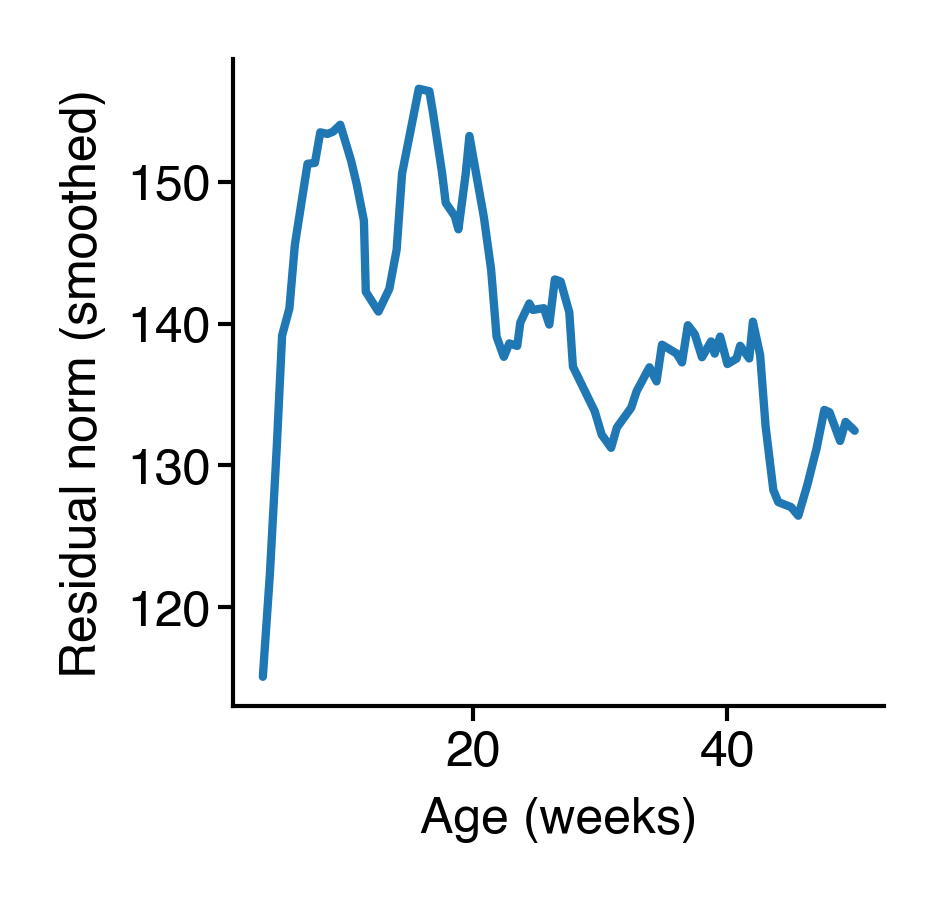

In [158]:
fig = figure(1.4, 1.4)
ax = sm_mouse_norm.mean(1).plot(ax=fig.gca())
# ax = sm_mouse_norm.drop(columns=['M5_02']).mean(1).plot(ax=fig.gca())
ax.set(ylabel="Residual norm (smoothed)", xlabel="Age (weeks)")
sns.despine()

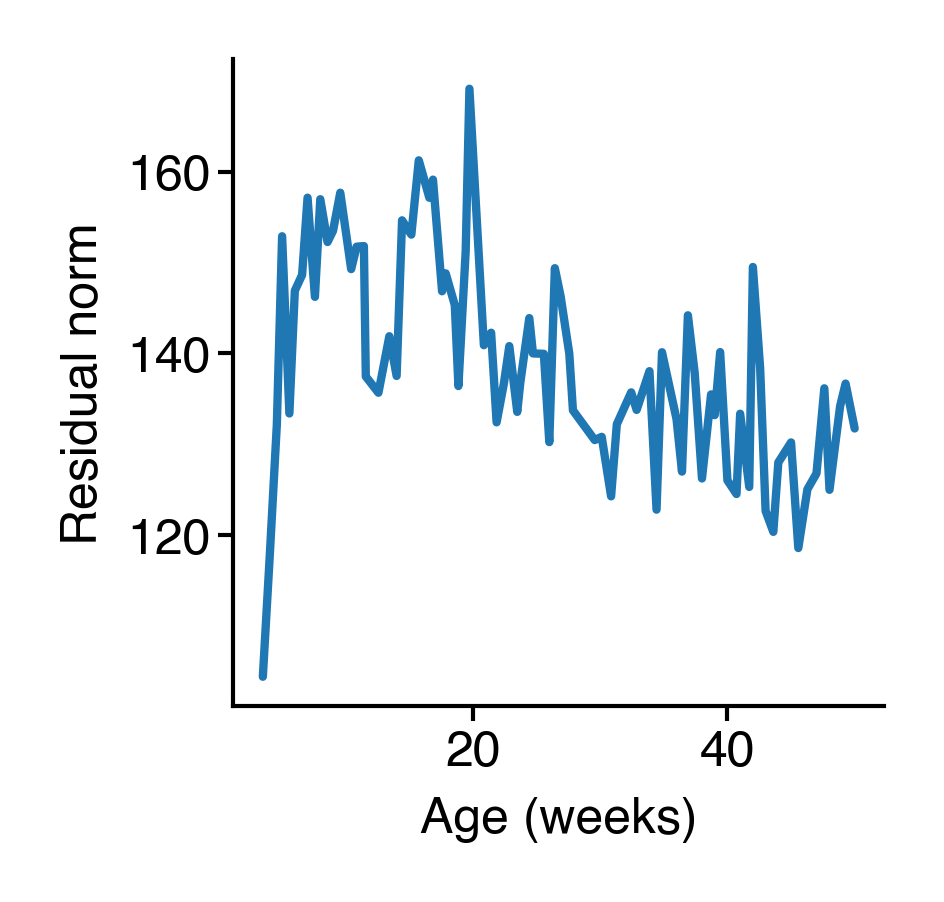

In [160]:
fig = figure(1.4, 1.4)
ax = mouse_norm.mean(1).plot(ax=fig.gca())
# ax = mouse_norm.drop(columns=['M5_02']).mean(1).plot(ax=fig.gca())
ax.set(ylabel="Residual norm", xlabel="Age (weeks)")
sns.despine()

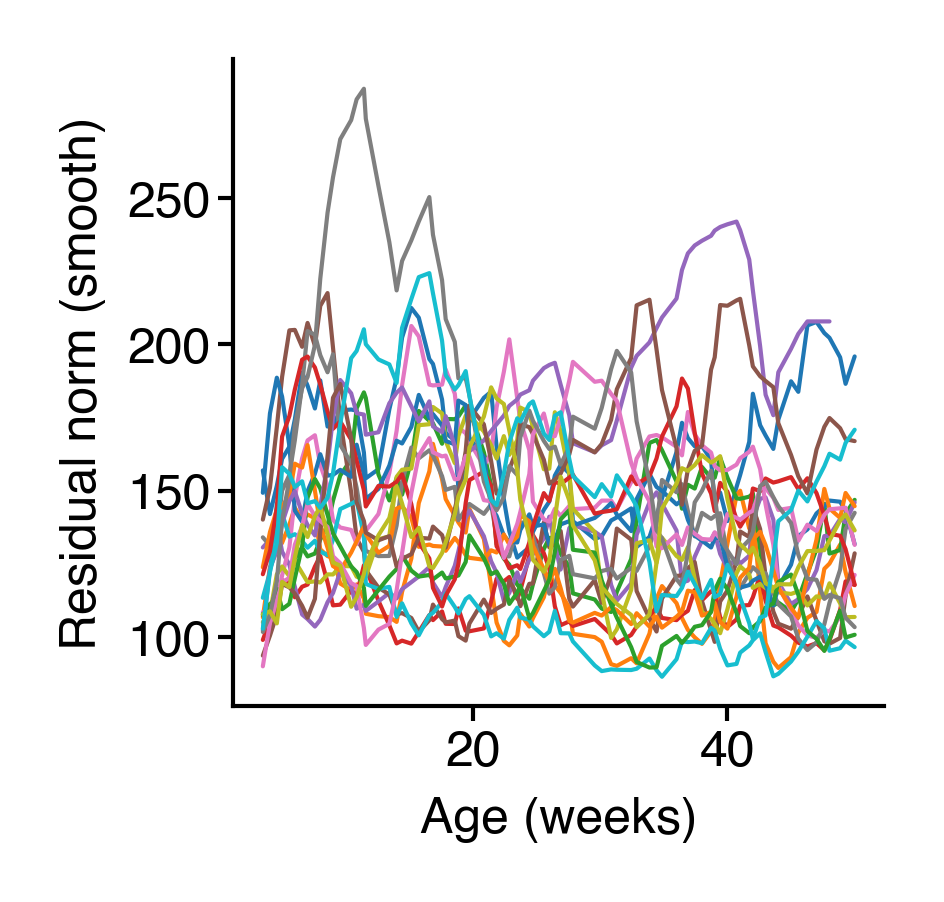

In [151]:
fig = figure(1.4, 1.4)
ax = sm_mouse_norm.plot(ax=fig.gca(), legend=False, lw=0.5)
ax.set(ylabel="Residual norm (smooth)", xlabel="Age (weeks)")
sns.despine()

In [161]:
bias_projection = {}
for mouse, _df in resid_df.groupby('mouse'):
    bias = animal_bias.loc[mouse]
    proj = _df @ bias
    bias_projection[mouse] = proj.droplevel('mouse')

In [162]:
bias_projection = pd.concat(bias_projection).reset_index().pivot_table(index='age', columns='level_0', values=0)

In [164]:
sm_bias_projection = bias_projection.rolling(7, center=True, min_periods=1, win_type='exponential').mean(tau=1.5)

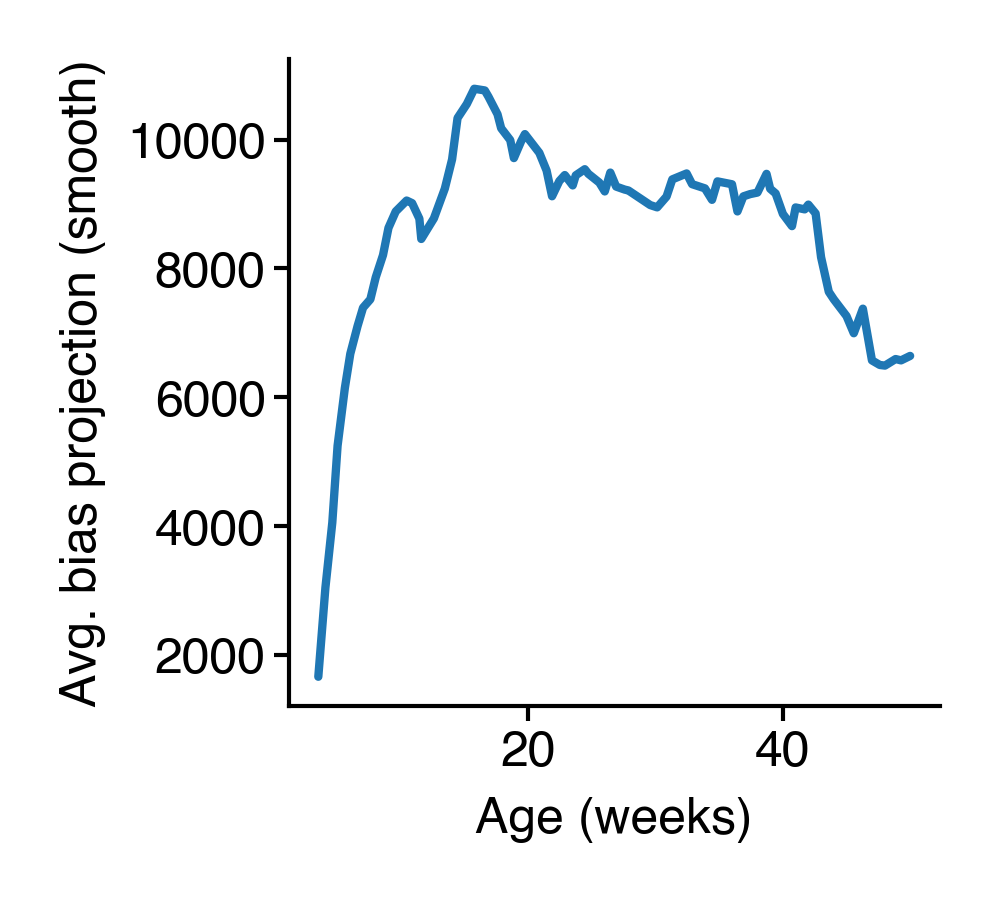

In [172]:
fig = figure(1.4, 1.4)
ax = sm_bias_projection.mean(1).plot(ax=fig.gca(),)
ax.set(ylabel="Avg. bias projection (smooth)", xlabel="Age (weeks)")
sns.despine()

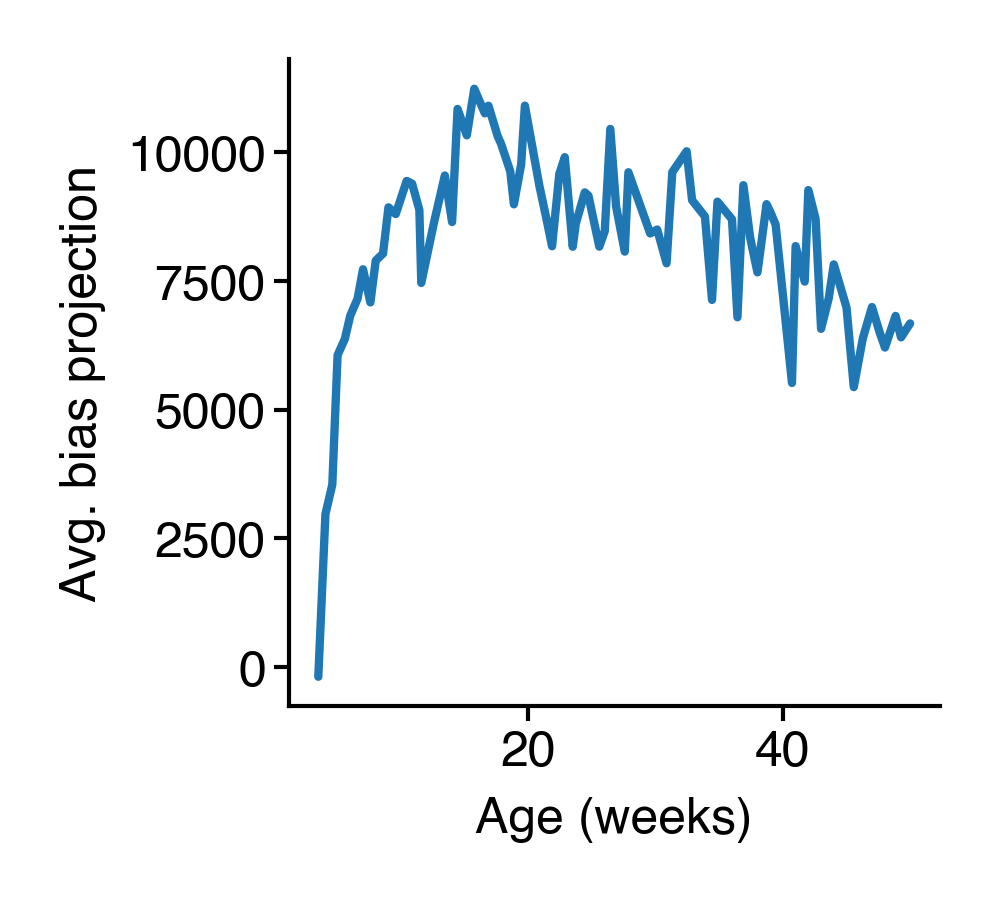

In [171]:
fig = figure(1.4, 1.4)
ax = bias_projection.mean(1).plot(ax=fig.gca(),)
ax.set(ylabel="Avg. bias projection", xlabel="Age (weeks)")
sns.despine()

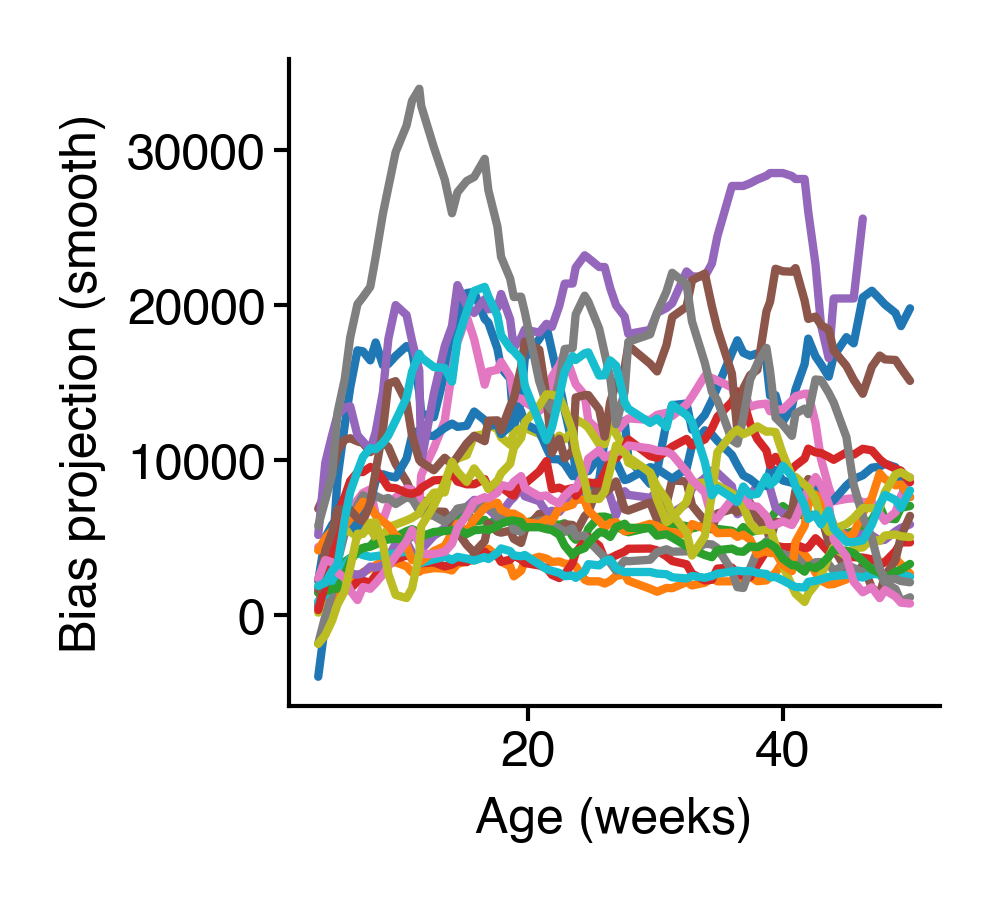

In [175]:
fig = figure(1.4, 1.4)
ax = sm_bias_projection.plot(ax=fig.gca(), legend=False)
ax.set(ylabel="Bias projection (smooth)", xlabel="Age (weeks)")
sns.despine()

## Normalize by usage

In [177]:
sample = sample / sample.sum(1).to_numpy()[:, None]

In [178]:
age_avg = sample.groupby('age').mean()

In [179]:
resid_df = sample.droplevel(['subject_name', 'session_name', 'uuid', 'date'])

In [180]:
resid_df = resid_df - age_avg

In [196]:
sns.heatmap(resid_df.loc['M1_01'].droplevel)

syllables            0         2         4         5         6         7   \
bin age                                                                     
0   3.485714  -0.000761 -0.013882 -0.001013  0.033556 -0.001065  0.008565   
1   4.045113  -0.001283 -0.005241 -0.000568  0.001612 -0.002098  0.007695   
2   4.585714  -0.000831  0.000757 -0.001099  0.015237  0.002737  0.052291   
3   5.000000  -0.000863  0.036251 -0.000601  0.005829 -0.005324  0.016622   
4   5.571429  -0.000633  0.036068 -0.002964  0.001681 -0.011050  0.017769   
...                 ...       ...       ...       ...       ...       ...   
87  47.616543  0.000834  0.053534  0.011336 -0.042296 -0.000347 -0.008971   
88  48.022556 -0.000262  0.056694  0.014443 -0.044387  0.000241 -0.000150   
89  48.857143 -0.000633  0.042983 -0.000721 -0.034349  0.002583 -0.014539   
90  49.285713 -0.004369  0.047993 -0.004579 -0.014434 -0.000485  0.016157   
91  50.000000  0.001806  0.057370  0.008398 -0.039863  0.001654 -0.010447   

syllables            9         10        11        12  ...        77  \
bin age                                                ...             
0   3.485714   0.003396 -0.001362 -0.033599 -0.004042  ... -0.000159   
1   4.045113   0.007070 -0.002733  0.000242 -0.002101  ... -0.000306   
2   4.585714   0.003342 -0.002395 -0.014267 -0.002119  ... -0.000479   
3   5.000000   0.002477  0.000230 -0.007119 -0.001461  ... -0.000566   
4   5.571429  -0.011519 -0.002361  0.000974 -0.002615  ... -0.000693   
...                 ...       ...       ...       ...  ...       ...   
87  47.616543 -0.001385  0.002115  0.004790  0.000013  ... -0.001118   
88  48.022556 -0.001951  0.000499  0.008369  0.004017  ... -0.000631   
89  48.857143  0.008463 -0.001552  0.008020  0.003702  ... -0.001532   
90  49.285713 -0.001814  0.000134 -0.001241  0.002938  ... -0.001477   
91  50.000000  0.002726 -0.001606  0.007522 -0.001824  ... -0.000391   

syllables            79        83        84        85        90        93  \
bin age                                                                     
0   3.485714  -0.000369 -0.001072 -0.002432 -0.000015 -0.003671 -0.004445   
1   4.045113  -0.001038 -0.002306 -0.004482 -0.002103  0.005449  0.000853   
2   4.585714  -0.000327  0.001608 -0.001900 -0.001735 -0.003259 -0.001690   
3   5.000000  -0.005266  0.004958 -0.010847  0.005688  0.012268 -0.000607   
4   5.571429  -0.005840  0.000864 -0.011849  0.010177  0.010871 -0.000372   
...                 ...       ...       ...       ...       ...       ...   
87  47.616543  0.000121 -0.000679  0.000003  0.010746 -0.002536  0.000831   
88  48.022556 -0.002775 -0.006195  0.001684  0.005688  0.002702  0.004106   
89  48.857143 -0.008692 -0.011326 -0.003565  0.004964  0.004732  0.000829   
90  49.285713 -0.007547 -0.008159 -0.003715  0.002708  0.000636  0.004582   
91  50.000000  0.000222 -0.002011  0.000442  0.007234  0.001102  0.001951   

syllables            95        97        98  
bin age                                      
0   3.485714  -0.004433  0.000083 -0.003717  
1   4.045113  -0.003703  0.000452  0.003521  
2   4.585714  -0.004840 -0.000778 -0.002895  
3   5.000000  -0.002877 -0.003529  0.000423  
4   5.571429   0.002697 -0.003936  0.000342  
...                 ...       ...       ...  
87  47.616543  0.027040 -0.002174  0.018930  
88  48.022556  0.029967 -0.000253  0.003909  
89  48.857143  0.022868 -0.004012  0.010214  
90  49.285713  0.011614 -0.002264  0.003404  
91  50.000000  0.024046  0.000322  0.009218  

[81 rows x 58 columns]

In [181]:
animal_bias = resid_df.groupby('mouse').mean()

In [182]:
mouse_norm = {}
for mouse, _df in resid_df.groupby('mouse'):
    mouse_norm[mouse] = pd.Series(np.linalg.norm(_df, axis=1), _df.index.get_level_values('age'))

In [183]:
mouse_norm = pd.concat(mouse_norm).reset_index().pivot_table(index='age', columns='level_0', values=0)

In [184]:
sm_mouse_norm = mouse_norm.interpolate(limit=3).rolling(7, center=True, min_periods=1, win_type='exponential').mean(tau=1.5)

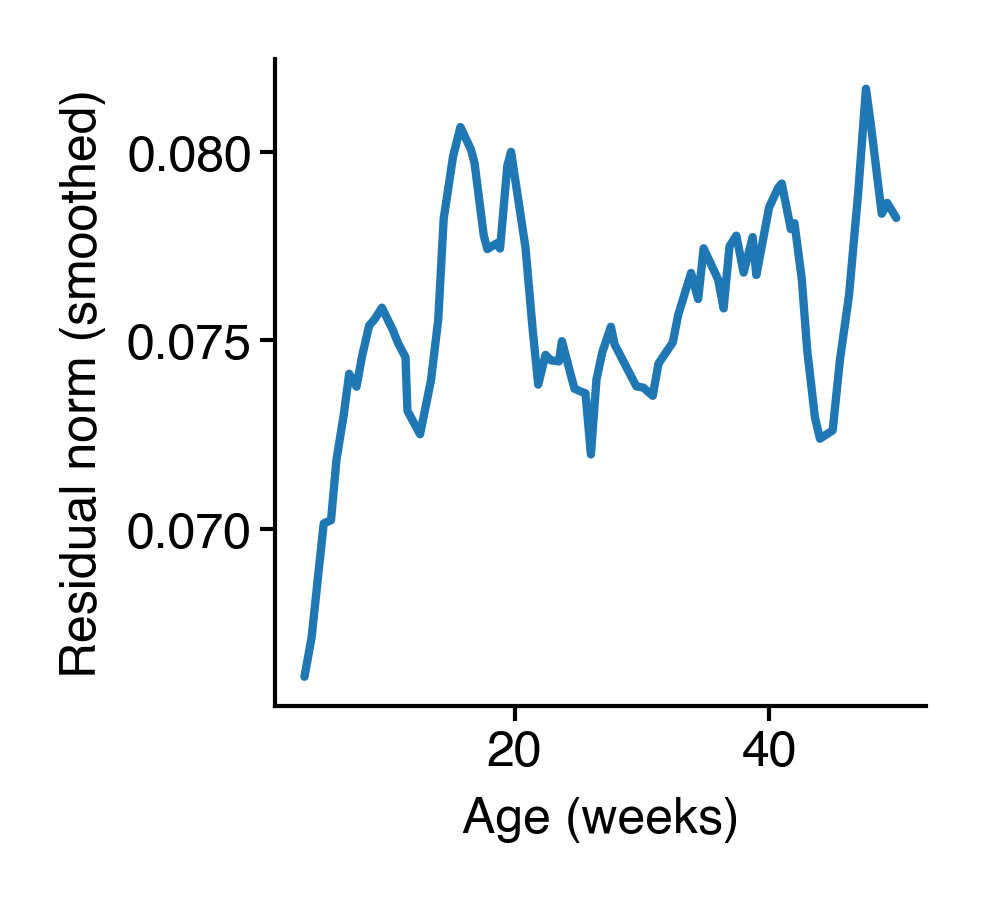

In [185]:
fig = figure(1.4, 1.4)
ax = sm_mouse_norm.mean(1).plot(ax=fig.gca())
# ax = sm_mouse_norm.drop(columns=['M5_02']).mean(1).plot(ax=fig.gca())
ax.set(ylabel="Residual norm (smoothed)", xlabel="Age (weeks)")
sns.despine()

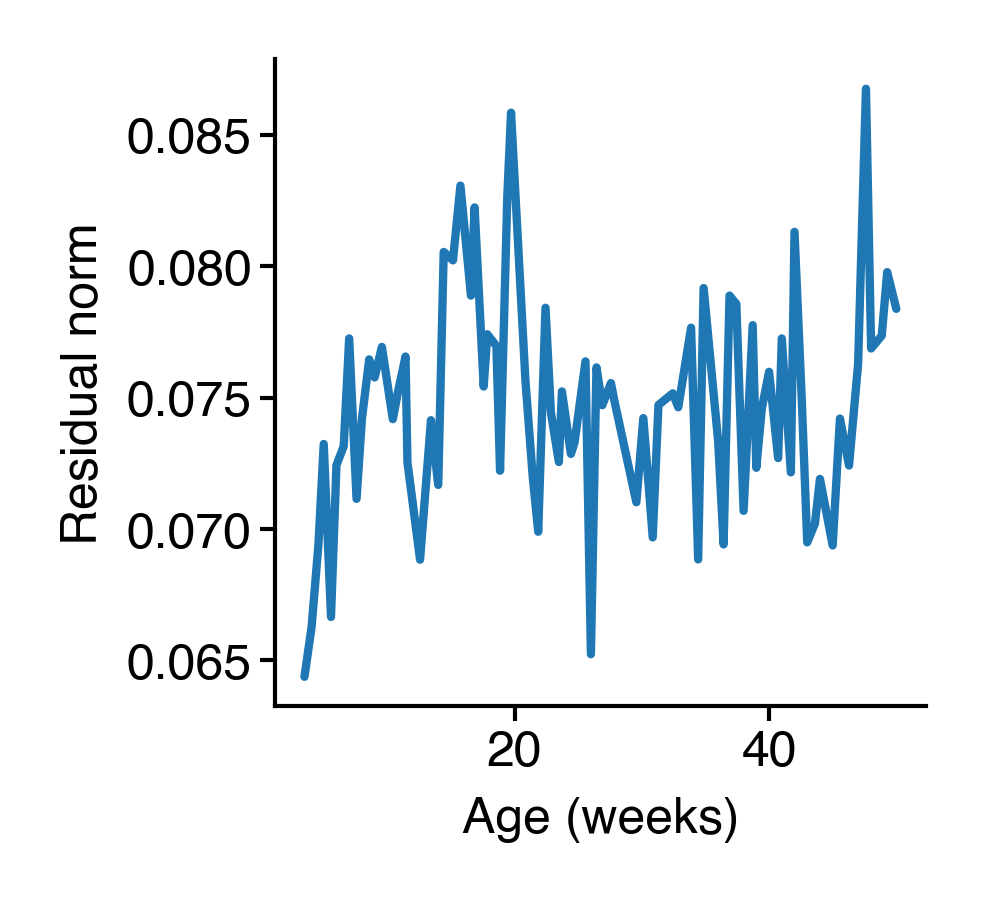

In [186]:
fig = figure(1.4, 1.4)
ax = mouse_norm.mean(1).plot(ax=fig.gca())
# ax = mouse_norm.drop(columns=['M5_02']).mean(1).plot(ax=fig.gca())
ax.set(ylabel="Residual norm", xlabel="Age (weeks)")
sns.despine()

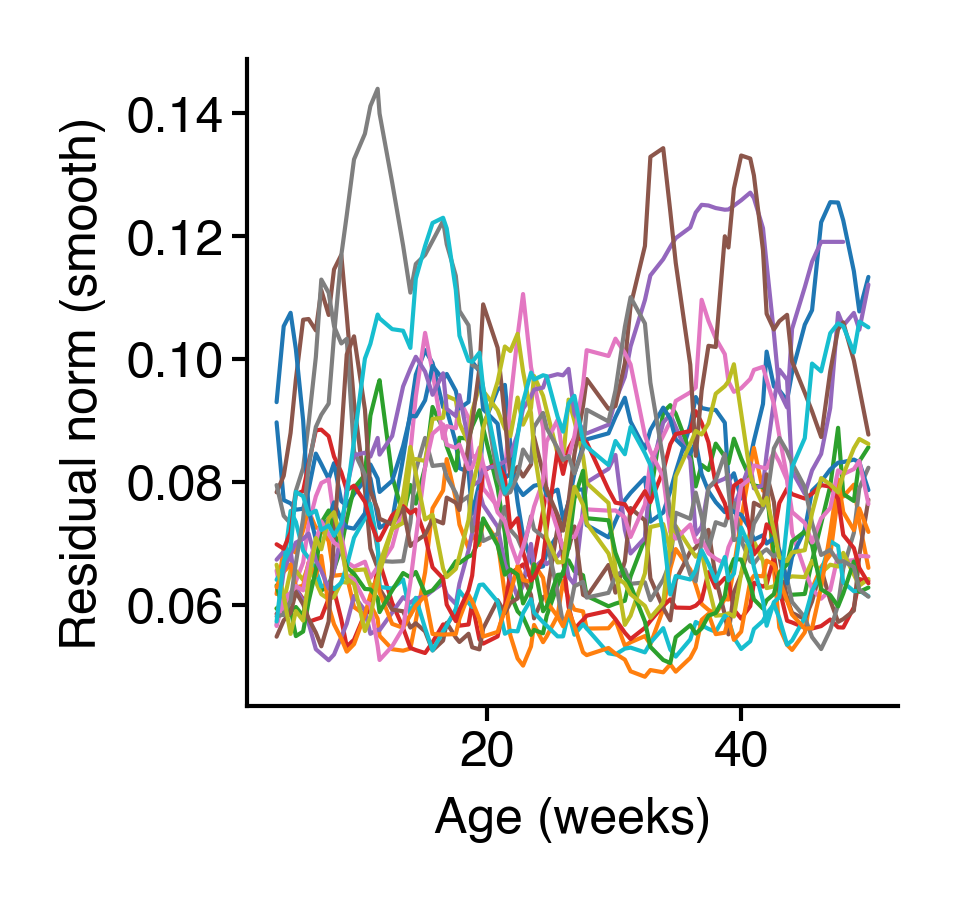

In [187]:
fig = figure(1.4, 1.4)
ax = sm_mouse_norm.plot(ax=fig.gca(), legend=False, lw=0.5)
ax.set(ylabel="Residual norm (smooth)", xlabel="Age (weeks)")
sns.despine()

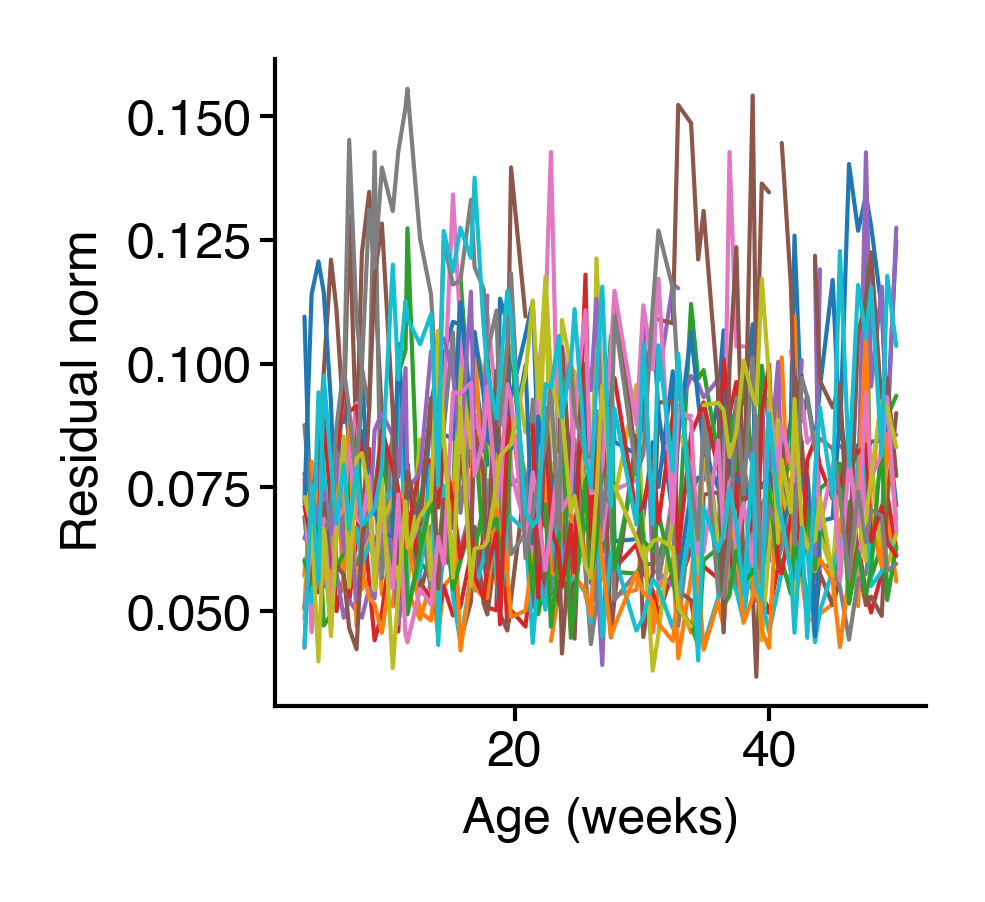

In [197]:
fig = figure(1.4, 1.4)
ax = mouse_norm.plot(ax=fig.gca(), legend=False, lw=0.5)
ax.set(ylabel="Residual norm", xlabel="Age (weeks)")
sns.despine()

In [188]:
bias_projection = {}
for mouse, _df in resid_df.groupby('mouse'):
    bias = animal_bias.loc[mouse]
    proj = _df @ bias
    bias_projection[mouse] = proj.droplevel('mouse')

In [189]:
bias_projection = pd.concat(bias_projection).reset_index().pivot_table(index='age', columns='level_0', values=0)

In [190]:
sm_bias_projection = bias_projection.rolling(7, center=True, min_periods=1, win_type='exponential').mean(tau=1.5)

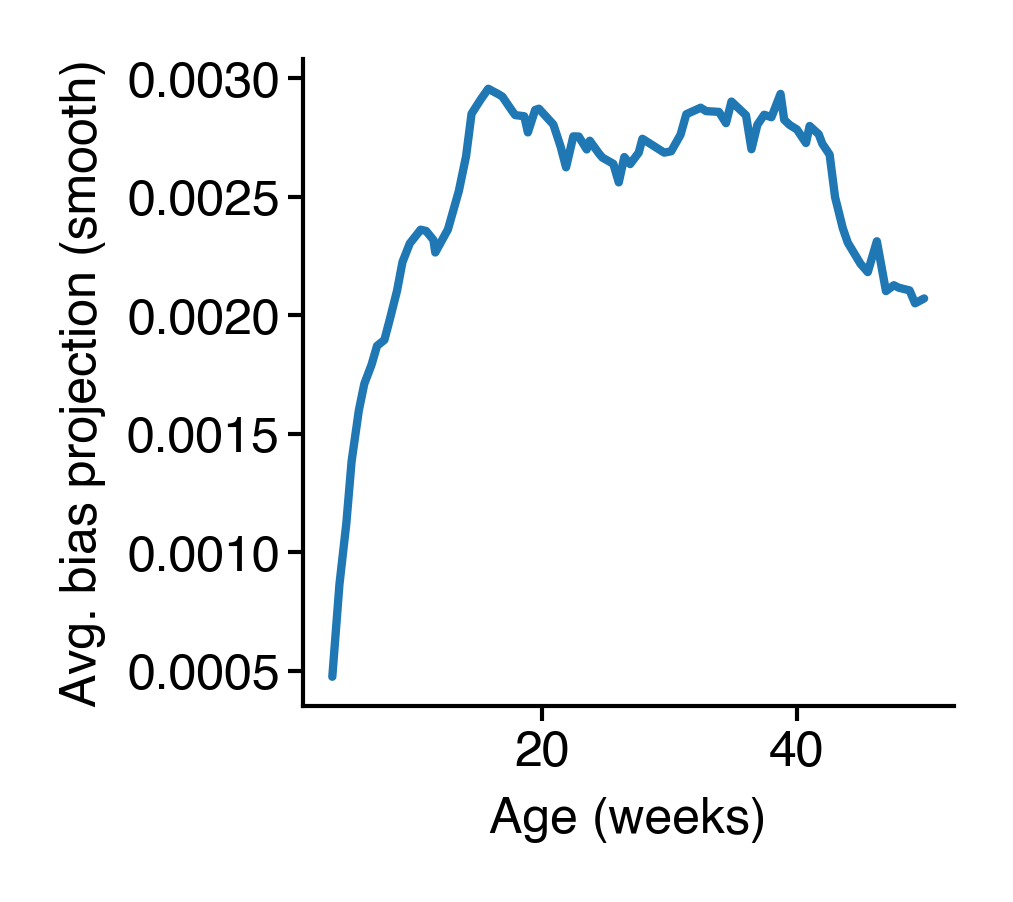

In [191]:
fig = figure(1.4, 1.4)
ax = sm_bias_projection.mean(1).plot(ax=fig.gca(),)
ax.set(ylabel="Avg. bias projection (smooth)", xlabel="Age (weeks)")
sns.despine()

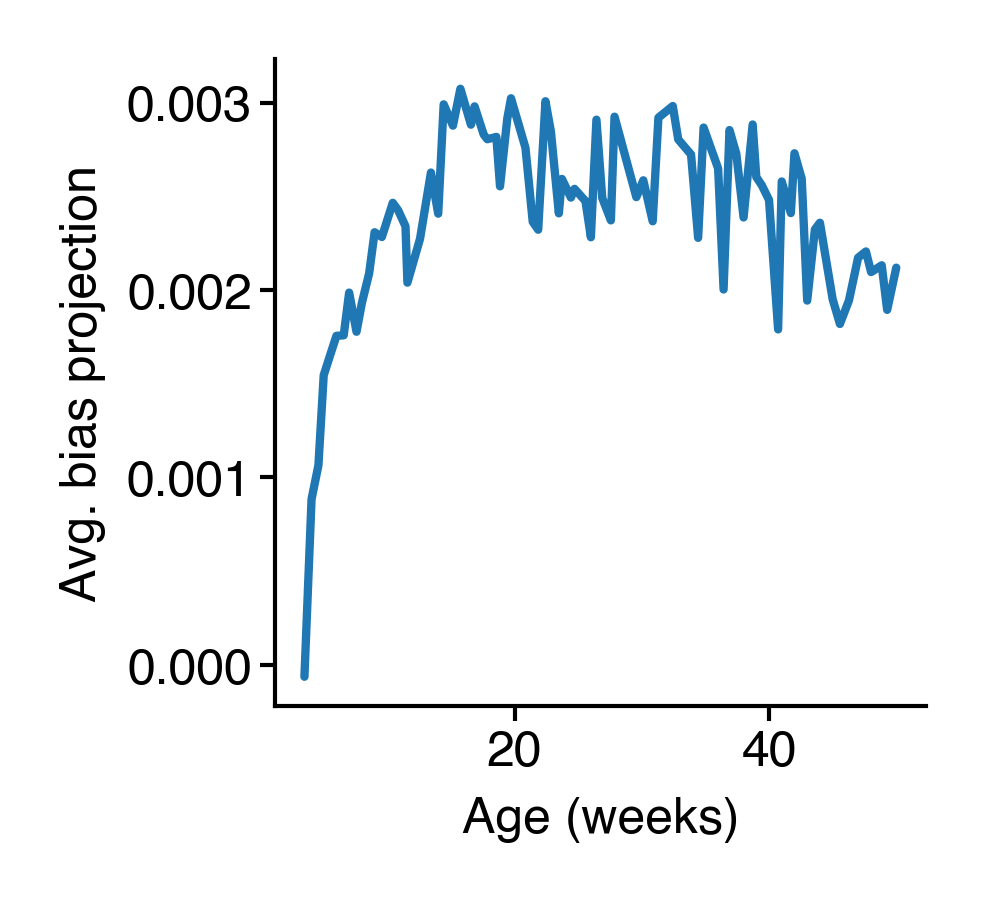

In [192]:
fig = figure(1.4, 1.4)
ax = bias_projection.mean(1).plot(ax=fig.gca(),)
ax.set(ylabel="Avg. bias projection", xlabel="Age (weeks)")
sns.despine()

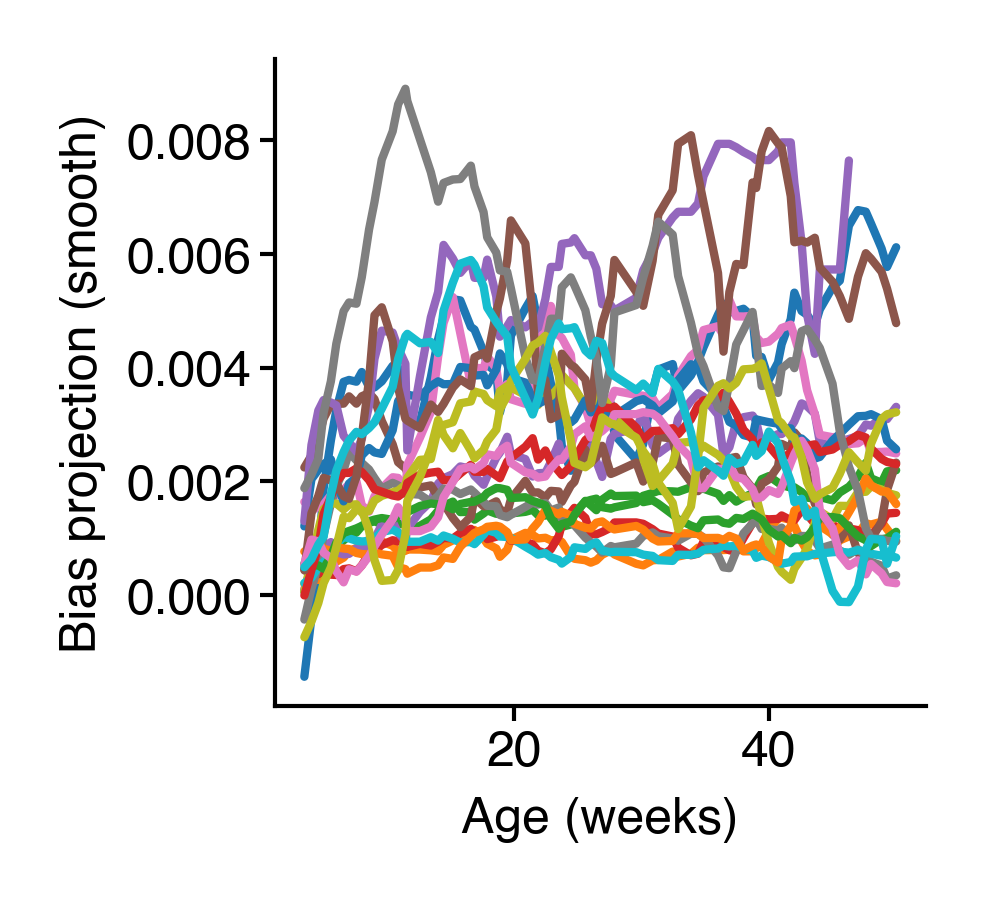

In [193]:
fig = figure(1.4, 1.4)
ax = sm_bias_projection.plot(ax=fig.gca(), legend=False)
ax.set(ylabel="Bias projection (smooth)", xlabel="Age (weeks)")
sns.despine()

## Females

In [198]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_females_raw_counts_matrix_v00.parquet')
df = df[keep_syllables]

bins = pd.cut(df.index.get_level_values('age'), 92, labels=False)

idx = list(df.index.names)

sample = df.reset_index().groupby(['mouse', bins], observed=True).first()
sample.index.rename("bin", level=1, inplace=True)
sample_map = sample.groupby('bin')['age'].mean()
sample = sample.reset_index().set_index(idx)

sample = sample.reset_index(level='age')
sample['age'] = sample['bin'].map(sample_map)

sample = sample.set_index(["bin", "age"], append=True)

In [199]:
sample = sample / sample.sum(1).to_numpy()[:, None]

In [200]:
age_avg = sample.groupby('age').mean()

In [201]:
resid_df = sample.droplevel(['subject_name', 'session_name', 'uuid', 'date'])

In [202]:
resid_df = resid_df - age_avg

In [205]:
resid_df

syllables                  0         2         4         5         6   \
mouse bin age                                                           
F1_01 0   3.442857  -0.000159 -0.005778  0.001004 -0.015895  0.000241   
      1   4.000000  -0.000400  0.019499 -0.002384 -0.000622  0.011327   
      2   4.571429   0.000896  0.008416  0.000226 -0.006385  0.015349   
      3   5.000000  -0.000246  0.013873 -0.000552 -0.012393  0.010120   
      4   5.571429  -0.000764  0.012420 -0.003046 -0.006729  0.015230   
...                       ...       ...       ...       ...       ...   
F5_04 87  47.571430  0.008072  0.038303  0.001681 -0.025019 -0.002327   
      88  48.000000  0.002655  0.051080 -0.001063 -0.030743 -0.000811   
      89  48.857143  0.004000  0.017951  0.000536 -0.013277 -0.002744   
      90  49.285713  0.002655  0.033328  0.002627 -0.024164 -0.001867   
      91  50.000000  0.003552  0.025417  0.005950 -0.025758 -0.002529   

syllables                  7         9         10        11        12  ...  \
mouse bin age                                                          ...   
F1_01 0   3.442857  -0.000174 -0.015746 -0.001037  0.001333 -0.007800  ...   
      1   4.000000   0.005541 -0.006381  0.000492 -0.019087 -0.000316  ...   
      2   4.571429  -0.013177 -0.006351 -0.000686 -0.026302  0.003780  ...   
      3   5.000000   0.004248 -0.000864  0.000063 -0.019087  0.000205  ...   
      4   5.571429   0.003910 -0.014236 -0.003227 -0.010971 -0.004345  ...   
...                       ...       ...       ...       ...       ...  ...   
F5_04 87  47.571430 -0.010092 -0.011188  0.003230  0.001357 -0.000101  ...   
      88  48.000000 -0.013817 -0.015346 -0.001432  0.011079 -0.000797  ...   
      89  48.857143 -0.002737 -0.004749 -0.001707  0.000463 -0.003294  ...   
      90  49.285713  0.003668 -0.004413 -0.000612  0.003265 -0.000624  ...   
      91  50.000000 -0.003691 -0.009151  0.001929 -0.003431  0.001273  ...   

syllables                  77        79        83        84        85  \
mouse bin age                                                           
F1_01 0   3.442857  -0.000124 -0.000284  0.001546  0.003060 -0.010185   
      1   4.000000  -0.000288  0.001829  0.006919 -0.002281 -0.005239   
      2   4.571429  -0.000214  0.001168  0.007346  0.000654 -0.003035   
      3   5.000000  -0.000581 -0.000801  0.002239 -0.003113 -0.004186   
      4   5.571429  -0.000516  0.001142 -0.000026 -0.006342 -0.005602   
...                       ...       ...       ...       ...       ...   
F5_04 87  47.571430  0.003103  0.008788 -0.005589  0.003718 -0.001712   
      88  48.000000 -0.001706 -0.001225 -0.004449  0.009151 -0.002061   
      89  48.857143  0.001866  0.012779 -0.008372  0.008413 -0.004289   
      90  49.285713 -0.000012  0.010395 -0.008447  0.007102 -0.002570   
      91  50.000000  0.000001  0.013574 -0.005345  0.000354 -0.003596   

syllables                  90        93        95        97        98  
mouse bin age                                                          
F1_01 0   3.442857  -0.004993  0.001115 -0.007914  0.000350  0.001562  
      1   4.000000   0.005478 -0.003052 -0.007938  0.000430  0.012352  
      2   4.571429  -0.007099 -0.001832 -0.002831  0.003027  0.035610  
      3   5.000000  -0.002071 -0.005494 -0.006399  0.000322  0.010027  
      4   5.571429  -0.008562 -0.004410 -0.010118  0.000509  0.014113  
...                       ...       ...       ...       ...       ...  
F5_04 87  47.571430 -0.005644  0.002590  0.001851 -0.000998  0.014803  
      88  48.000000 -0.000589 -0.000685  0.000390 -0.001534  0.012373  
      89  48.857143 -0.002301  0.000387  0.001119 -0.000492  0.019390  
      90  49.285713 -0.004389 -0.000868 -0.001234 -0.001144  0.007042  
      91  50.000000 -0.000850  0.003542  0.003470  0.001818  0.018196  

[1598 rows x 58 columns]

<Axes: xlabel='syllables', ylabel='age'>

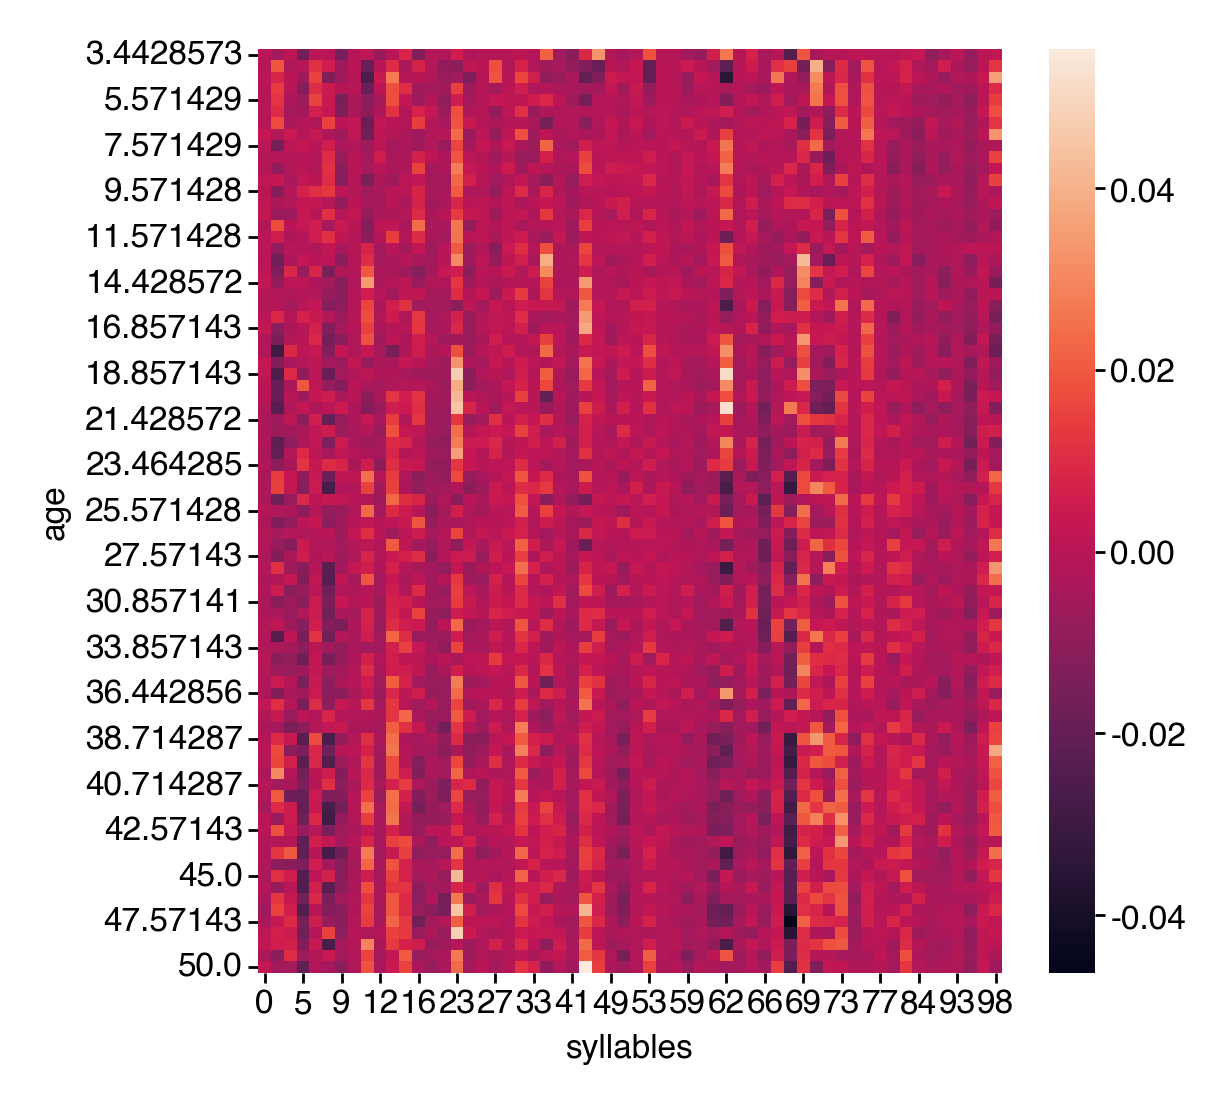

In [207]:
sns.heatmap(resid_df.loc['F1_01'].droplevel('bin'))

In [208]:
animal_bias = resid_df.groupby('mouse').mean()

In [209]:
mouse_norm = {}
for mouse, _df in resid_df.groupby('mouse'):
    mouse_norm[mouse] = pd.Series(np.linalg.norm(_df, axis=1), _df.index.get_level_values('age'))

In [210]:
mouse_norm = pd.concat(mouse_norm).reset_index().pivot_table(index='age', columns='level_0', values=0)

In [211]:
sm_mouse_norm = mouse_norm.interpolate(limit=3).rolling(7, center=True, min_periods=1, win_type='exponential').mean(tau=1.5)

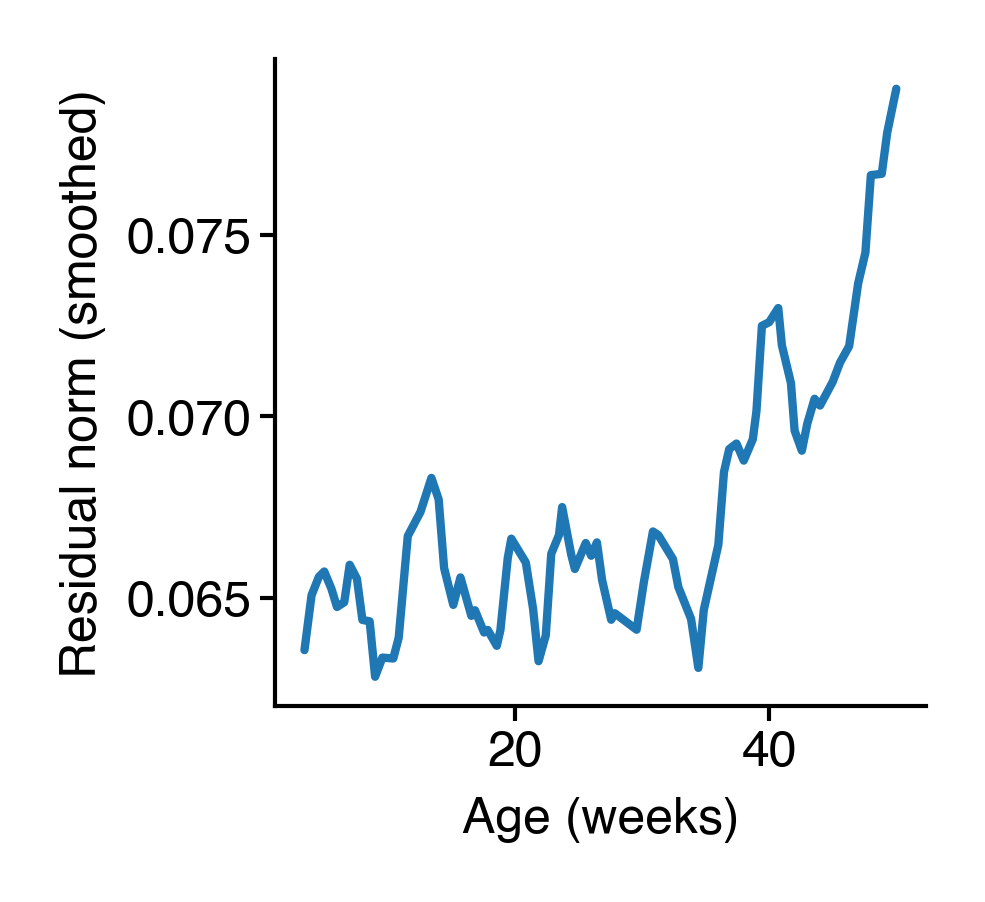

In [229]:
fig = figure(1.4, 1.4)
ax = sm_mouse_norm.drop(columns=['F4_03']).mean(1).plot(ax=fig.gca())
# ax = sm_mouse_norm.drop(columns=['M5_02']).mean(1).plot(ax=fig.gca())
ax.set(ylabel="Residual norm (smoothed)", xlabel="Age (weeks)")
sns.despine()

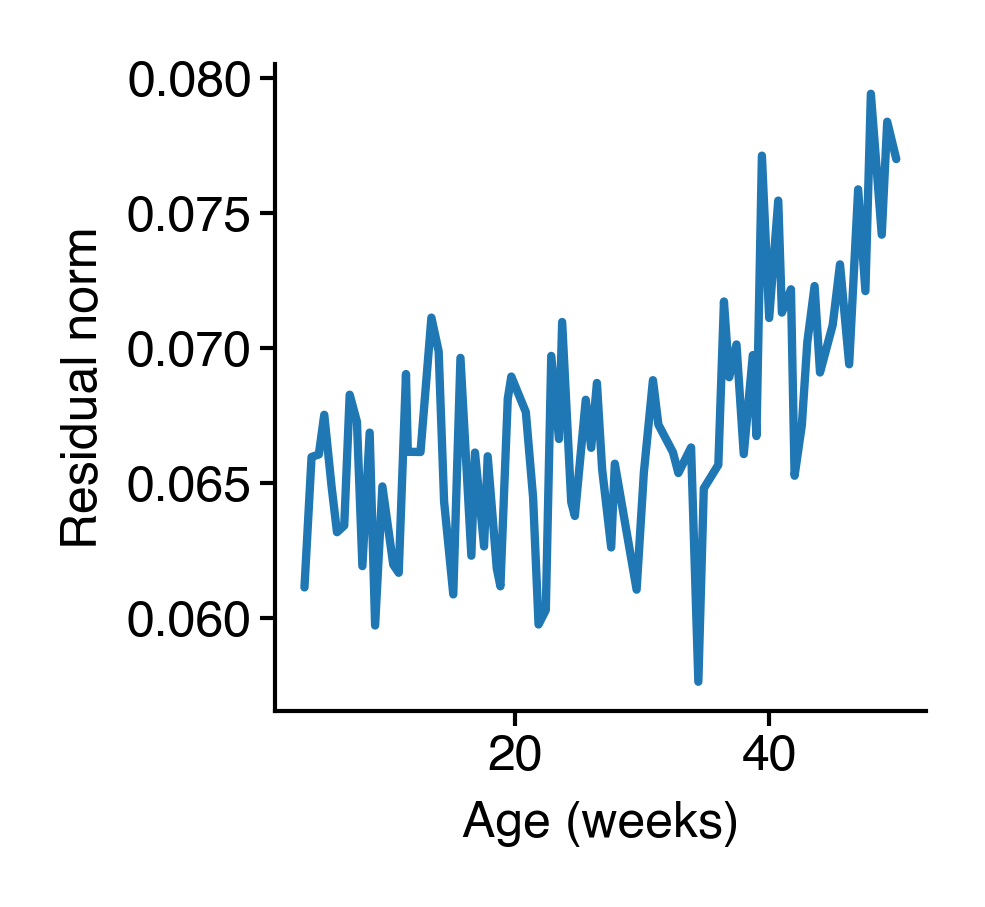

In [228]:
fig = figure(1.4, 1.4)
ax = mouse_norm.drop(columns=['F4_03']).mean(1).plot(ax=fig.gca())
# ax = mouse_norm.drop(columns=['M5_02']).mean(1).plot(ax=fig.gca())
ax.set(ylabel="Residual norm", xlabel="Age (weeks)")
sns.despine()

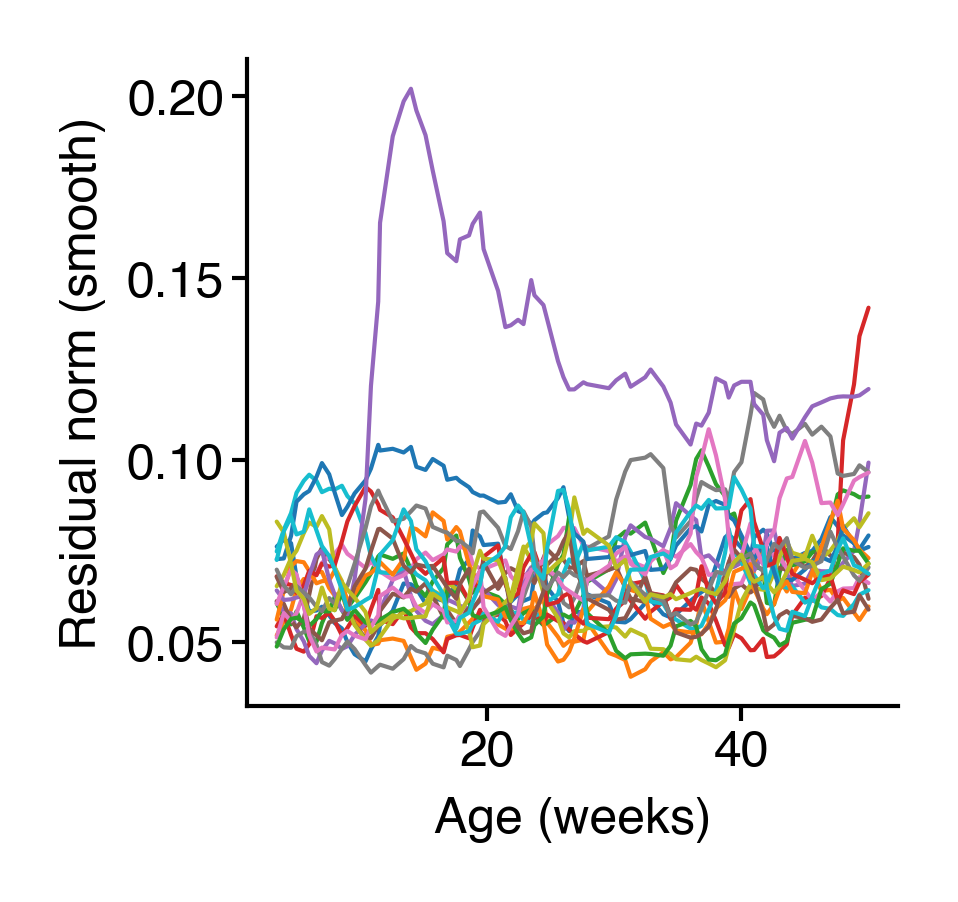

In [214]:
fig = figure(1.4, 1.4)
ax = sm_mouse_norm.plot(ax=fig.gca(), legend=False, lw=0.5)
ax.set(ylabel="Residual norm (smooth)", xlabel="Age (weeks)")
sns.despine()

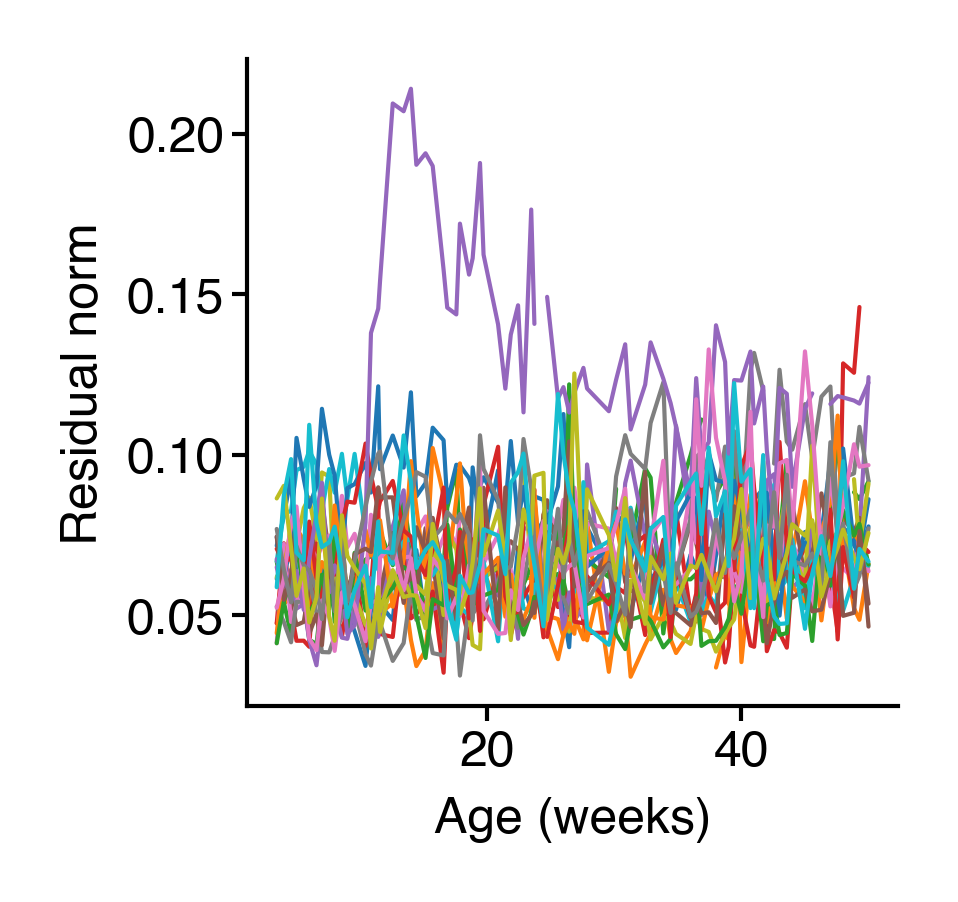

In [215]:
fig = figure(1.4, 1.4)
ax = mouse_norm.plot(ax=fig.gca(), legend=False, lw=0.5)
ax.set(ylabel="Residual norm", xlabel="Age (weeks)")
sns.despine()

In [216]:
bias_projection = {}
for mouse, _df in resid_df.groupby('mouse'):
    bias = animal_bias.loc[mouse]
    proj = _df @ bias
    bias_projection[mouse] = proj.droplevel('mouse')

In [217]:
bias_projection = pd.concat(bias_projection).reset_index().pivot_table(index='age', columns='level_0', values=0)

In [218]:
sm_bias_projection = bias_projection.rolling(7, center=True, min_periods=1, win_type='exponential').mean(tau=1.5)

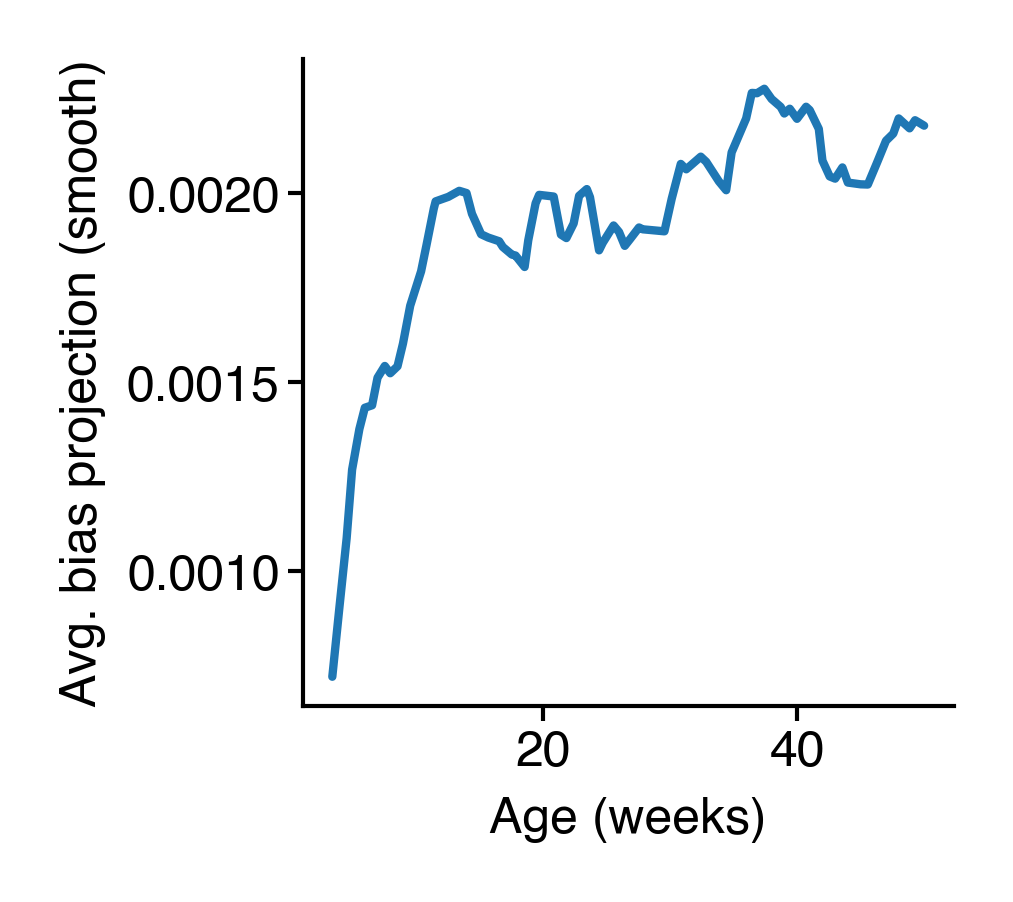

In [227]:
fig = figure(1.4, 1.4)
ax = sm_bias_projection.drop(columns=['F4_03']).mean(1).plot(ax=fig.gca(),)
ax.set(ylabel="Avg. bias projection (smooth)", xlabel="Age (weeks)")
sns.despine()

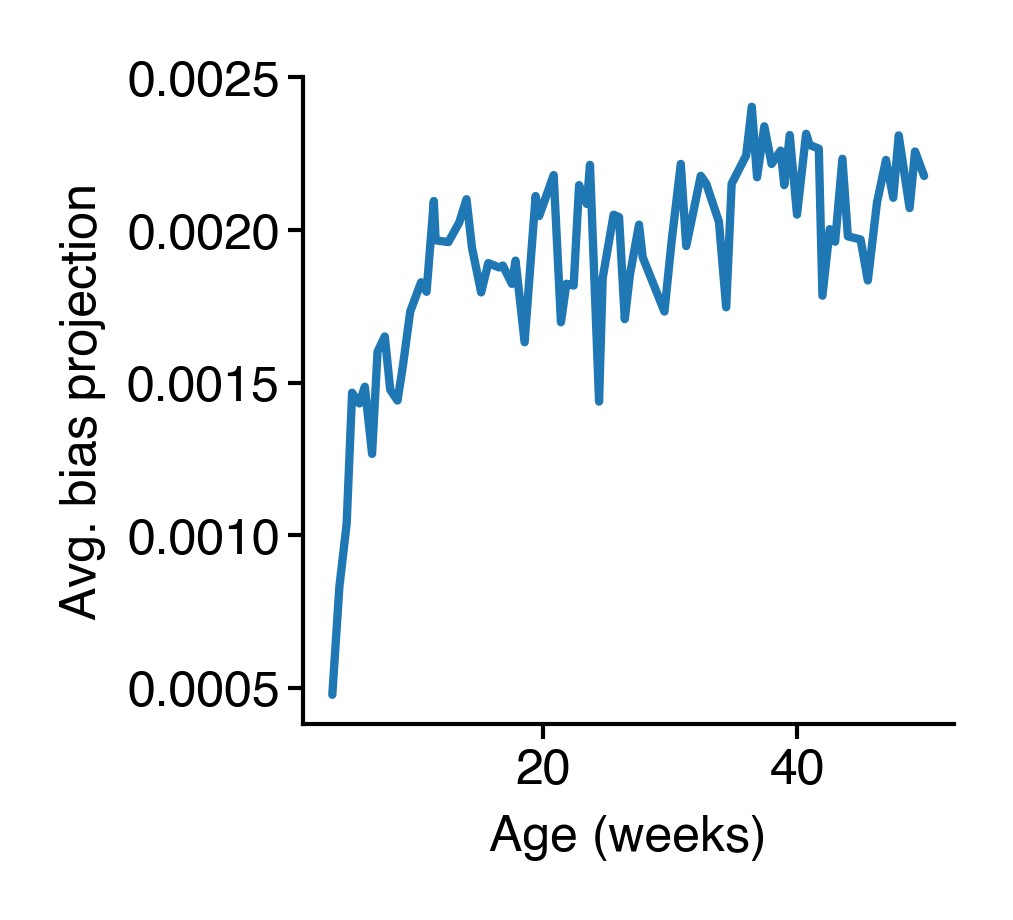

In [226]:
fig = figure(1.4, 1.4)
ax = bias_projection.drop(columns=['F4_03']).mean(1).plot(ax=fig.gca(),)
ax.set(ylabel="Avg. bias projection", xlabel="Age (weeks)")
sns.despine()

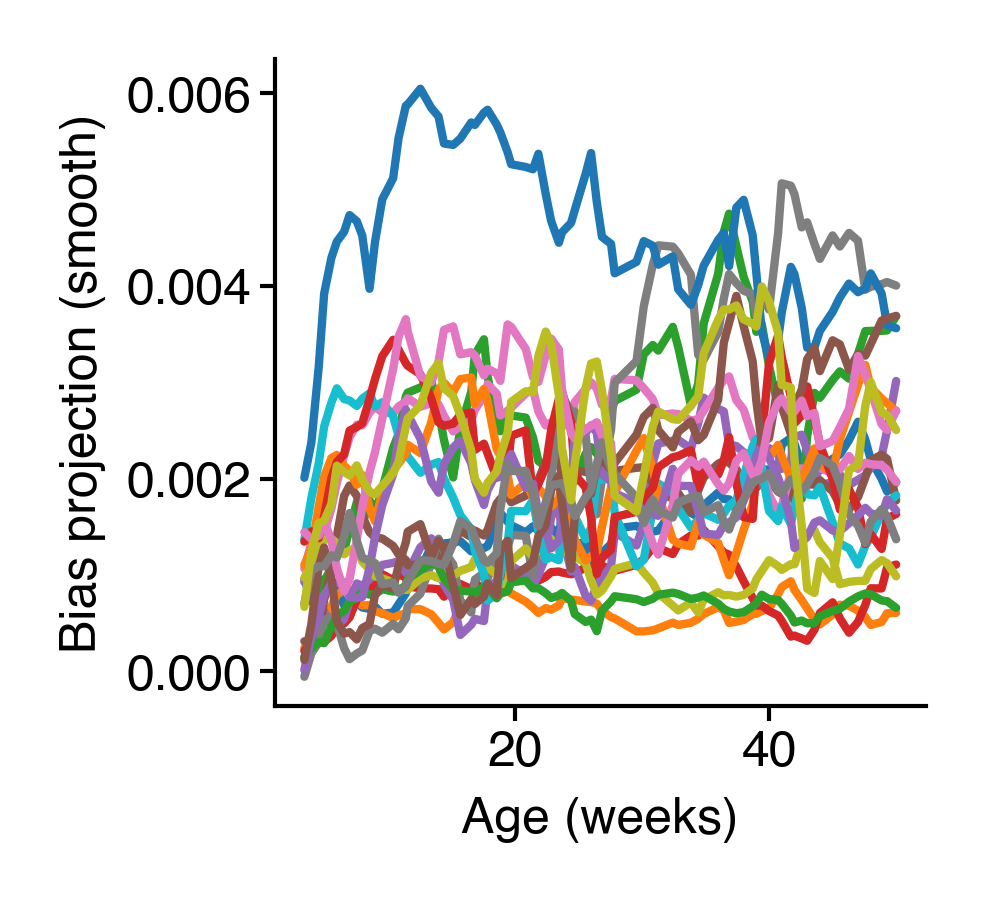

In [225]:
fig = figure(1.4, 1.4)
ax = sm_bias_projection.drop(columns=['F4_03']).plot(ax=fig.gca(), legend=False)
ax.set(ylabel="Bias projection (smooth)", xlabel="Age (weeks)")
sns.despine()